# Testing The Bare Model with The Modified Model

## Bare Model

Using device: cuda
Test Accuracy: 97.67%

Classification Report:
              precision    recall  f1-score   support

      desert       1.00      0.91      0.95       150
  green_area       0.91      1.00      0.96       150
       water       1.00      1.00      1.00       150
      cloudy       1.00      1.00      1.00       150

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



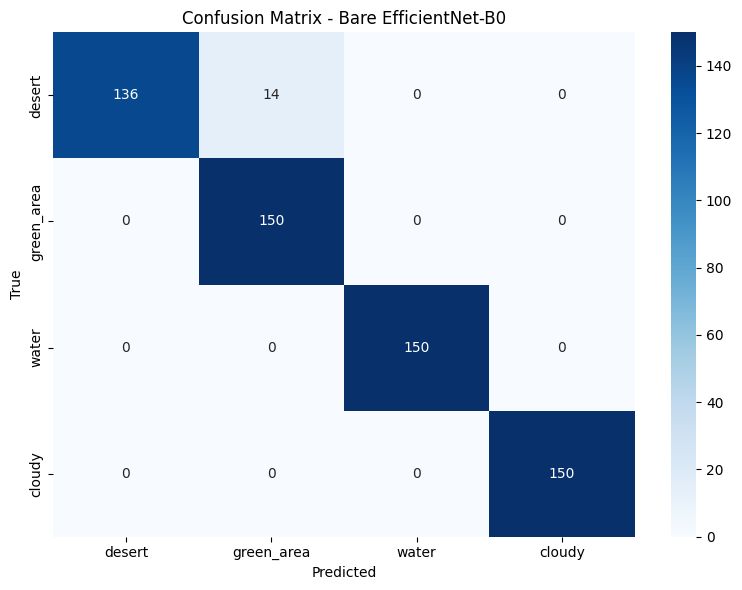

Confusion matrix saved as 'confusion_matrix_efficientnet_b0_bare.png'
Total number of parameters: 4012672


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import timm
import os

# Define the BareEfficientNetB0 model class (same as in your training code)
class BareEfficientNetB0(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define test transformations (same as validation in your code)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join("processed_data", "test"), transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = BareEfficientNetB0(num_classes=4)
model.load_state_dict(torch.load("efficientnet_b0_bare_2.pth"))
model.to(device)
model.eval()

# Class names (based on your dataset: desert, green_area, water, cloudy)
class_names = ["desert", "green_area", "water", "cloudy"]

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Bare EfficientNet-B0")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_efficientnet_b0__bare.png")
plt.show()  # Display the plot
plt.close()
print("Confusion matrix saved as 'confusion_matrix_efficientnet_b0_bare.png'")

# Assuming `model` is your trained or defined model
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params}")

# Modified V1

Using device: cuda
Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

      desert       1.00      1.00      1.00       150
  green_area       1.00      1.00      1.00       150
       water       1.00      1.00      1.00       150
      cloudy       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



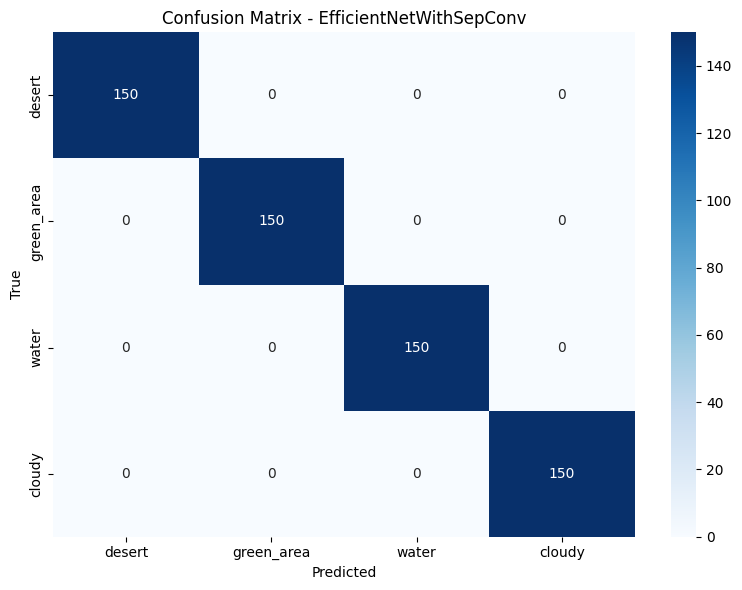

Confusion matrix saved as 'confusion_matrix_efficientnet_sepconv.png'
Total number of parameters: 4349824


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import timm
import os

# Define the EfficientNetWithSepConv model class
class EfficientNetWithSepConv(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Load the base model
        self.base = timm.create_model("efficientnet_b0", pretrained=False, features_only=False)
        # Extract the features before the classifier
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        # Define input features for the separable convolution
        in_features = 1280
        self.sep_conv = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, groups=in_features, padding=1),
            nn.Conv2d(in_features, 256, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.base(x)
        x = self.sep_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define test transformations (same as validation in the bare model code)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join("processed_data", "test"), transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = EfficientNetWithSepConv(num_classes=4)
# Load saved weights (update the path if the filename differs)
model.load_state_dict(torch.load("efficientnet_b0main_modified.pth"))
model.to(device)
model.eval()

# Class names (based on your dataset: desert, green_area, water, cloudy)
class_names = ["desert", "green_area", "water", "cloudy"]

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNetWithSepConv")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_efficientnet_sepconv.png")
plt.show()  # Display the plot
plt.close()
print("Confusion matrix saved as 'confusion_matrix_efficientnet_sepconv.png'")



# Assuming `model` is your trained or defined model
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params}")

## Modified V2 Model

Using device: cuda
Test Accuracy: 99.50%

Classification Report:
              precision    recall  f1-score   support

      desert       0.99      1.00      0.99       150
  green_area       1.00      0.99      0.99       150
       water       0.99      1.00      1.00       150
      cloudy       1.00      0.99      1.00       150

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



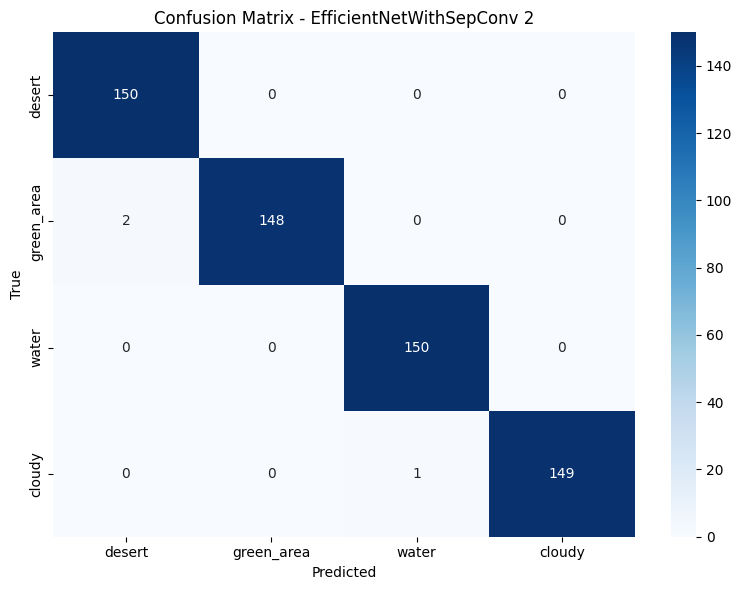

Confusion matrix saved as 'confusion_matrix_efficientnet_sepconv_2.png'
Total number of parameters: 4012700


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import timm
import os

# Define the EfficientNetWithMinimalHead model class
class EfficientNetWithMinimalHead(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model("efficientnet_b0", pretrained=False, features_only=False)
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        in_features = 1280
        self.head = nn.Sequential(
            nn.Conv2d(in_features, 4, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.3),
        )
        self.fc = nn.Linear(4, num_classes)
    
    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define test transformations (same as validation in the bare model code)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join("processed_data", "val"), transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model2 = EfficientNetWithMinimalHead(num_classes=4)
# Load saved weights (update the path if the filename differs)
model2.load_state_dict(torch.load("efficientnet_b0_2_modified.pth"))
model2.to(device)
model2.eval()

# Class names (based on your dataset: desert, green_area, water, cloudy)
class_names = ["desert", "green_area", "water", "cloudy"]

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNetWithSepConv 2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_efficientnet_sepconv_2.png")
plt.show()  # Display the plot
plt.close()
print("Confusion matrix saved as 'confusion_matrix_efficientnet_sepconv_2.png'")



# Assuming `model` is your trained or defined model
num_params = sum(p.numel() for p in model2.parameters())
print(f"Total number of parameters: {num_params}")